<a href="https://colab.research.google.com/github/comp-machine-learning-fall2022/portfolio-ssonghaophie/blob/main/Deep%20Learning/image%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Classification**

Image classification is a task that aims to assign groups to the image data by viewing it as a set of pixels or vectors. As the name suggests, it is a supervised learning that has a "true" class that we can compare the predicted class to calculate the accuracy of the fitted model. 

In this project, I will use **Convolutional Neural Network** (CNN) in deep learning algorithm to train and test the image data. 

Continuing from the anime example used in the project about Recommendation System, I'm using an **anime character face dataset** with the face of two main characters from the anime called "Kuroko's Basketball" (Kuroko no Basket), Kuroko and Kagami, distinguished. There are 50 face images cropped for each of them in the training set, and 10 each in the test set. 

Dataset from: https://github.com/developer0hye/Custom-CNN-based-Image-Classification-in-PyTorch

I'll be using a tensorflow library to load and preprocess this data that is not from the library, and fit the CNN model to it.

In [ ]:
# import block
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


## **1. Explore & Preprocess Data**


Information about loading custom image data from: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory


To first load the train data, I specified the hyperparameters as batch size = 80, image size = 256, and color mode = rgb. This means that 80 images of shape (256x256x3) will be in one batch. Note that the last dimension refers to color channels RGB. 

The train data was also splited into 80% training set and 20% validation set, so that I can first test the accuracy on the validation data before evaluating the test data.

**Batch size** decides the number of samples processed before the model is updated. In this case where there are 80 images in a train data, batch size of 80 means that it will take 1 **iteration** to complete 1 **epoch** (go through all of the train data once). Because it only takes 1 iteration for 1 epoch, the computation speed for training will be faster. 





In [ ]:
# load train data
# default settings except seed 1
data_train = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/CS294 Final Project/data/train',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=80,
    image_size=(256, 256),
    shuffle=True,
    seed=1,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

# load validation data
data_val = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/CS294 Final Project/data/train',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=20,
    image_size=(256, 256),
    shuffle=True,
    seed=1,
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

# load test data
data_test = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/CS294 Final Project/data/test',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=20,
    image_size=(256, 256),
    shuffle=True,
    seed=1,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 100 files belonging to 2 classes.
Using 80 files for training.
Found 100 files belonging to 2 classes.
Using 20 files for validation.
Found 20 files belonging to 2 classes.


In [ ]:
# names of two different anime character
# kagami = 0, kuroko = 1
class_names = data_train.class_names
print(class_names)

['kagami', 'kuroko']


We can visualize some images in the data by plotting it. Notice that the two characters look very different in our bare eyes.

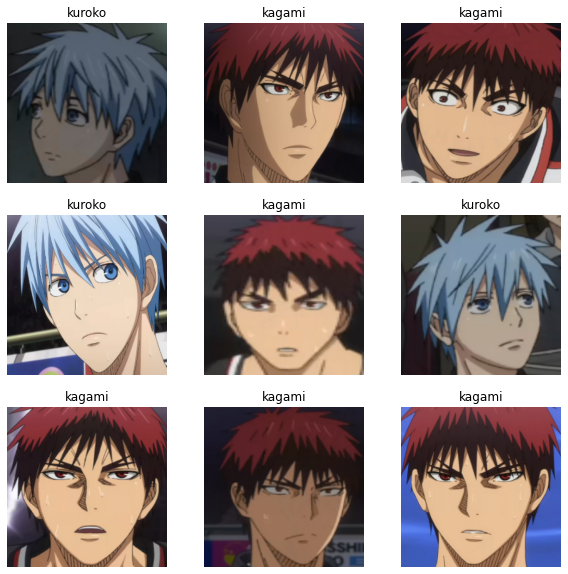

In [ ]:
# visualize the data

plt.figure(figsize=(10, 10))
for img, label in data_train.take(1):
  for i in range(9):
    # make 3X3 plot to fit 9 different images from train set
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(class_names[label[i]])
    plt.axis("off")

We can also print the shape of our data. Note that the size for the **image** is (80, 256, 256, 3), while the size for the **label** is (80,). The latter is a tensor that stores the name of the anime character as each labels.

In [ ]:
for imag, label in data_train:
  print(imag.shape)
  print(label.shape)


(80, 256, 256, 3)
(80,)


We should then configure the dataset to make sure that we can fetch the data from the computer without the I/O being blocked. 

**Dataset.cache** does that by keeping the images that were loaded first in memory so that it doesn't generate a conflict while training the model during each epoch.

**Dataset.prefetch** preprocesses the data and executes the model at the same time while training.

In [ ]:
# data configuration
AUTOTUNE = tf.data.AUTOTUNE

data_train = data_train.cache().shuffle(1).prefetch(buffer_size=AUTOTUNE)
data_val = data_val.cache().prefetch(buffer_size=AUTOTUNE)
data_test = data_test.cache().prefetch(buffer_size=AUTOTUNE)


## **2. Generate and Fit a Model**

Next, we will build the neural network with the layers.

**CNN** consists of an input layer, convolutional layers, pooling layers, other hidden layers, and an output layer. 

In a **convolutional layer**, a small filter (as a matrix) moves accross the image to check if that feature can be found in the image or not. It does an element-wise multiplication and sum that result for each placement. This outputs a numerical feature map that makes CNN extract the pattern.

In a **pooling layer**, the convolved matrix is divided into small sub-matrices, and the sub-matrices get summarized. This increases the efficiency of CNN by reducing complexity. Note that it is most common to take the max of each piece for the pooling, having a max-pool layer.

**.Flatten()** layer flattens the matrix into a vector so that it can prepare the number of inputs as 1D.

**.Dense()** layer takes a vector as an input and connects it just like a fully connected hidden layer. We can specify the size of the outputs that this layer sends out to the next and the activation function.

**.Dropout()** layer drops a portion of the nodes mid-stream. This reduces overfitting.

In [ ]:
# build a model
num_classes = len(class_names)

model = Sequential([
  # normalization layer that divides the size of the image by the maximum value for a channel (255)
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  # convolutional layer and pooling layer activating on relu
  layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # flatten layer that converts matrixes into vector
  layers.Flatten(),
  # dropout layer that regularizes the network
  tf.keras.layers.Dropout(0.2),
  # hidden layer that activates on relu
  layers.Dense(128, activation='relu'),
  # output layer with 2 nodes corresponding to each class
  layers.Dense(num_classes)
])

We then compile this model by setting the optimizer, loss, and metrics.


**Adaptive Moment Estimation (Adam)** is an optimizer that takes estimations of the first and second moments of the gradient to adapt the learning rate to update each weight of the neural network.

It is relatively more straightforward, and computationally efficient.

I will use a built-in loss function that calculates the **cross-entropy loss** between the labels and prediction for the loss.

I will focus on the **accuracy** for metrics. 

Notice that accuracy is more analogical to how many errors there are, and loss is more like how much the error is spread over the data.

About Adam:
https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/#:~:text=Adam%20is%20a%20replacement%20optimization,sparse%20gradients%20on%20noisy%20problems.

About Accuracy vs Loss: https://datascience.stackexchange.com/questions/42599/what-is-the-relationship-between-the-accuracy-and-the-loss-in-deep-learning


In [ ]:
# compile a model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

See how the number of parameters decrease as we add convolutional layers, and decrease as we drop and trim the output nodes.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 262144)            0

We then fit the model and run 30 epochs. 

In [ ]:
# fit the model
epochs=30
history = model.fit(
  data_train,
  validation_data=data_val,
  epochs=epochs
)

Epoch 1/30
1/1 [==============================] - 13s 13s/step - loss: 0.7174 - accuracy: 0.4500 - val_loss: 26.1747 - val_accuracy: 0.3500
Epoch 2/30
1/1 [==============================] - 9s 9s/step - loss: 19.5224 - accuracy: 0.5375 - val_loss: 0.7295 - val_accuracy: 0.6500
Epoch 3/30
1/1 [==============================] - 10s 10s/step - loss: 0.7461 - accuracy: 0.6375 - val_loss: 0.2600 - val_accuracy: 0.9000
Epoch 4/30
1/1 [==============================] - 10s 10s/step - loss: 0.0392 - accuracy: 0.9875 - val_loss: 0.6776 - val_accuracy: 0.8500
Epoch 5/30
1/1 [==============================] - 13s 13s/step - loss: 0.1259 - accuracy: 0.9625 - val_loss: 0.5644 - val_accuracy: 0.8500
Epoch 6/30
1/1 [==============================] - 8s 8s/step - loss: 0.0818 - accuracy: 0.9750 - val_loss: 0.2635 - val_accuracy: 0.8500
Epoch 7/30
1/1 [==============================] - 10s 10s/step - loss: 0.0226 - accuracy: 0.9875 - val_loss: 0.0593 - val_accuracy: 0.9500
Epoch 8/30
1/1 [=============

We can graph the accuracy and loss of training and validation data by each epoch to see how the model does in long run.

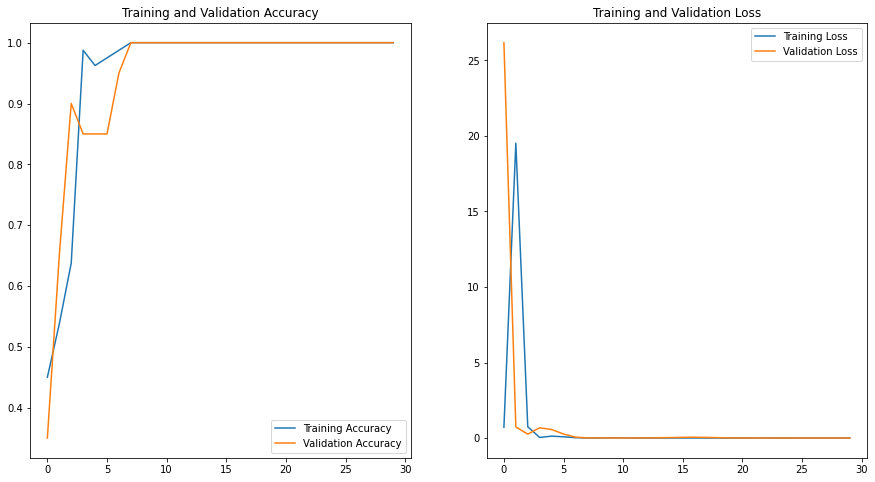

In [ ]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# plot for accuracy
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plot for loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

According to the accuracy and loss, it looks like I could have stopped at the epoch 10 because both train and validation accuracy converge at 1 (100% accuracy) starting at epoch 8. 

Now that I trained the model well enough, I can test how well the model classifies other images of two characters using the test data.

## **3. Make a Prediction using the Model**

In [ ]:
# function for making prediction
def pred_img(data):
  # set prediction and score
  predictions = model.predict(data)
  score = tf.nn.softmax(predictions)

  # visualize the data
  plt.figure(figsize=(10, 10))
  for images, labels in data.take(1):
    # plot all the images
    for i in range(20):
      # make 5x5 plot for 20 images
      ax = plt.subplot(5, 5, i+1)
      plt.imshow(images[i].numpy().astype("uint8"))
      # print predicted name of the character and the percent confidence
      plt.title(class_names[np.argmax(score[i])] + ": {:.2f}%".format(100 * np.max(score[i])))
      plt.axis("off")


1/1 [==============================] - 4s 4s/step


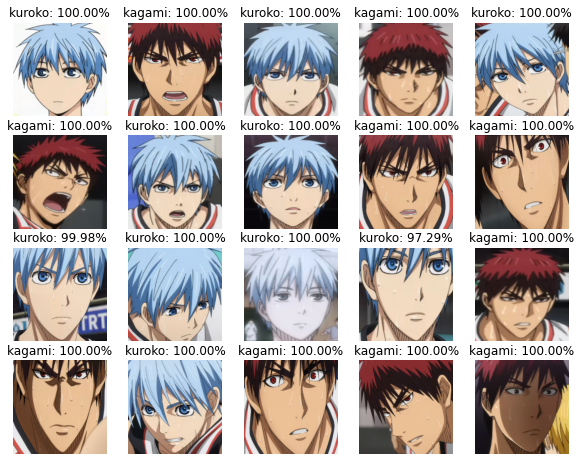

In [ ]:
pred_img(data_test)

The model classified all of the character image correctly from the test with nearly all of them having 100% confidence level. It makes sense because the model was fully trained to have 100% accuracy on both train and validation data. Therefore, this is a very successful model. 

This might have been an easier classification task because Kuroko and Kagami's hair color are very different, directly mapping blue with Kuroko and red with Kagami. This feature must have been caught in the convoluting process, where a lot of the small kernel must have represented their distinct hair colors from RGB channel.

Later, I can gather larger data with more anime characters to generalize the model so that it can be applied to more broad data.

Sources:

Lab 22:

https://colab.research.google.com/drive/15ZWa44ow2bWmQOWMfjZeHAdXJFBx_jSR?usp=sharing#scrollTo=EMguodqFISRa


Tensorflow built-in methods:

https://www.tensorflow.org/tutorials/images/cnn
https://www.tensorflow.org/tutorials/images/classification


Optimizer, accuracy, loss:

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/#:~:text=Adam%20is%20a%20replacement%20optimization,sparse%20gradients%20on%20noisy%20problems.

https://datascience.stackexchange.com/questions/42599/what-is-the-relationship-between-the-accuracy-and-the-loss-in-deep-learning
